# Transformer

在之前的章节中，我们已经介绍了主流的神经网络架构如卷积神经网络（CNNs）和循环神经网络（RNNs）。让我们进行一些回顾：

- CNNs 易于并行化，却不适合捕捉变长序列内的依赖关系。
- RNNs 适合捕捉长距离变长序列的依赖，但是却难以实现并行化处理序列。

为了整合CNN和RNN的优势，[\[Vaswani et al., 2017\]](https://d2l.ai/chapter_references/zreferences.html#vaswani-shazeer-parmar-ea-2017) 创新性地使用注意力机制设计了Transformer模型。该模型利用attention机制实现了并行化捕捉序列依赖，并且同时处理序列的每个位置的tokens，上述优势使得Transformer模型在性能优异的同时大大减少了训练时间。

图10.3.1展示了Transformer模型的架构，与9.7节的seq2seq模型相似，Transformer同样基于编码器-解码器架构，其区别主要在于以下三点：
1. Transformer blocks：将seq2seq模型重的循环网络替换为了Transformer Blocks，该模块包含一个多头注意力层（Multi-head Attention Layers）以及两个position-wise feed-forward networks（FFN）。对于解码器来说，另一个多头注意力层被用于接受编码器的隐藏状态。
2. Add and norm：多头注意力层和前馈网络的输出被送到两个“add and norm”层进行处理，该层包含残差结构以及层归一化。
3. Position encoding：由于自注意力层并没有区分元素的顺序，所以一个位置编码层被用于向序列元素里添加位置信息。

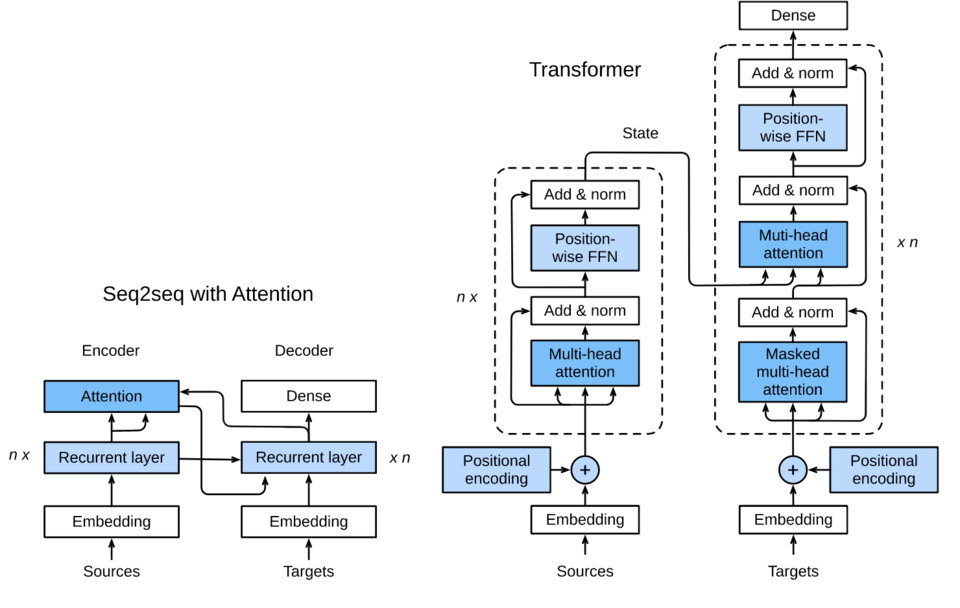

$$
Fig.10.3.1\ Transformer 架构.
$$


在接下来的部分，我们将会带领大家实现Transformer里全新的子结构，并且构建一个神经机器翻译模型用以训练和测试。

In [26]:
import os
import math
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('/home/kesci/input/d2len9900')
import d2l

以下是复制了上一小节中 masked softmax 实现，这里就不再赘述了。

In [27]:
def SequenceMask(X, X_len,value=-1e6):
    maxlen = X.size(1)
    X_len = X_len.to(X.device)
    #print(X.size(),torch.arange((maxlen),dtype=torch.float)[None, :],'\n',X_len[:, None] )
    mask = torch.arange((maxlen), dtype=torch.float, device=X.device)
    mask = mask[None, :] < X_len[:, None]
    #print(mask)
    X[~mask]=value
    return X

def masked_softmax(X, valid_length):
    # X: 3-D tensor, valid_length: 1-D or 2-D tensor
    softmax = nn.Softmax(dim=-1)
    if valid_length is None:
        return softmax(X)
    else:
        shape = X.shape
        if valid_length.dim() == 1:
            try:
                valid_length = torch.FloatTensor(valid_length.numpy().repeat(shape[1], axis=0))#[2,2,3,3]
            except:
                valid_length = torch.FloatTensor(valid_length.cpu().numpy().repeat(shape[1], axis=0))#[2,2,3,3]
        else:
            valid_length = valid_length.reshape((-1,))
        # fill masked elements with a large negative, whose exp is 0
        X = SequenceMask(X.reshape((-1, shape[-1])), valid_length)
 
        return softmax(X).reshape(shape)

# Save to the d2l package.
class DotProductAttention(nn.Module): 
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # query: (batch_size, #queries, d)
    # key: (batch_size, #kv_pairs, d)
    # value: (batch_size, #kv_pairs, dim_v)
    # valid_length: either (batch_size, ) or (batch_size, xx)
    def forward(self, query, key, value, valid_length=None):
        d = query.shape[-1]
        # set transpose_b=True to swap the last two dimensions of key
        scores = torch.bmm(query, key.transpose(1,2)) / math.sqrt(d)
        attention_weights = self.dropout(masked_softmax(scores, valid_length))
        return torch.bmm(attention_weights, value)

## 多头注意力层

在我们讨论多头注意力层之前，先来迅速理解以下自注意力（self-attention）的结构。自注意力模型是一个正规的注意力模型，序列的每一个元素对应的key，value，query是完全一致的。如图10.3.2 自注意力输出了一个与输入长度相同的表征序列，与循环神经网络相比，自注意力对每个元素输出的计算是并行的，所以我们可以高效的实现这个模块。

![Fig. 10.3.2 自注意力结构]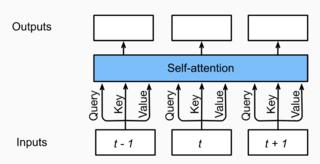

$$
Fig.10.3.2\ 自注意力结构
$$




多头注意力层包含$h$个并行的自注意力层，每一个这种层被成为一个head。对每个头来说，在进行注意力计算之前，我们会将query、key和value用三个现行层进行映射，这$h$个注意力头的输出将会被拼接之后输入最后一个线性层进行整合。
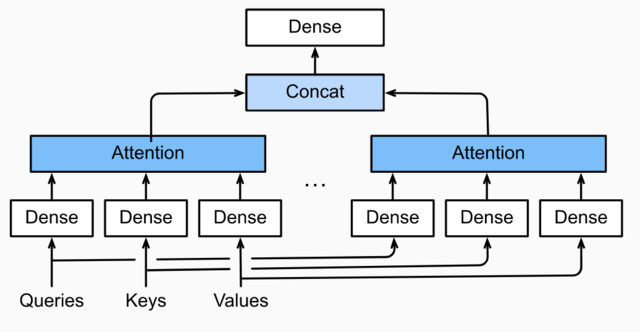

$$
Fig.10.3.3\ 多头注意力
$$


假设query，key和value的维度分别是$d_q$、$d_k$和$d_v$。那么对于每一个头$i=1,\ldots,h$，我们可以训练相应的模型权重$W_q^{(i)} \in \mathbb{R}^{p_q\times d_q}$、$W_k^{(i)} \in \mathbb{R}^{p_k\times d_k}$和$W_v^{(i)} \in \mathbb{R}^{p_v\times d_v}$，以得到每个头的输出：


$$
o^{(i)} = attention(W_q^{(i)}q, W_k^{(i)}k, W_v^{(i)}v)
$$


这里的attention可以是任意的attention function，比如前一节介绍的dot-product attention以及MLP attention。之后我们将所有head对应的输出拼接起来，送入最后一个线性层进行整合，这个层的权重可以表示为$W_o\in \mathbb{R}^{d_0 \times hp_v}$


$$
o = W_o[o^{(1)}, \ldots, o^{(h)}]
$$


接下来我们就可以来实现多头注意力了，假设我们有h个头，隐藏层权重 $hidden\_size = p_q = p_k = p_v$ 与query，key，value的维度一致。除此之外，因为多头注意力层保持输入与输出张量的维度不变，所以输出feature的维度也设置为 $d_0 = hidden\_size$。

In [28]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, dropout, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(input_size, hidden_size, bias=False)
        self.W_k = nn.Linear(input_size, hidden_size, bias=False)
        self.W_v = nn.Linear(input_size, hidden_size, bias=False)
        self.W_o = nn.Linear(hidden_size, hidden_size, bias=False)
    
    def forward(self, query, key, value, valid_length):
        # query, key, and value shape: (batch_size, seq_len, dim),
        # where seq_len is the length of input sequence
        # valid_length shape is either (batch_size, )
        # or (batch_size, seq_len).

        # Project and transpose query, key, and value from
        # (batch_size, seq_len, hidden_size * num_heads) to
        # (batch_size * num_heads, seq_len, hidden_size).
        
        query = transpose_qkv(self.W_q(query), self.num_heads)
        key = transpose_qkv(self.W_k(key), self.num_heads)
        value = transpose_qkv(self.W_v(value), self.num_heads)
        
        if valid_length is not None:
            # Copy valid_length by num_heads times
            device = valid_length.device
            valid_length = valid_length.cpu().numpy() if valid_length.is_cuda else valid_length.numpy()
            if valid_length.ndim == 1:
                valid_length = torch.FloatTensor(np.tile(valid_length, self.num_heads))
            else:
                valid_length = torch.FloatTensor(np.tile(valid_length, (self.num_heads,1)))

            valid_length = valid_length.to(device)
            
        output = self.attention(query, key, value, valid_length)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [29]:
def transpose_qkv(X, num_heads):
    # Original X shape: (batch_size, seq_len, hidden_size * num_heads),
    # -1 means inferring its value, after first reshape, X shape:
    # (batch_size, seq_len, num_heads, hidden_size)
    X = X.view(X.shape[0], X.shape[1], num_heads, -1)
    
    # After transpose, X shape: (batch_size, num_heads, seq_len, hidden_size)
    X = X.transpose(2, 1).contiguous()

    # Merge the first two dimensions. Use reverse=True to infer shape from
    # right to left.
    # output shape: (batch_size * num_heads, seq_len, hidden_size)
    output = X.view(-1, X.shape[2], X.shape[3])
    return output


# Saved in the d2l package for later use
def transpose_output(X, num_heads):
    # A reversed version of transpose_qkv
    X = X.view(-1, num_heads, X.shape[1], X.shape[2])
    X = X.transpose(2, 1).contiguous()
    return X.view(X.shape[0], X.shape[1], -1)

In [30]:
cell = MultiHeadAttention(5, 9, 3, 0.5)
X = torch.ones((2, 4, 5))
valid_length = torch.FloatTensor([2, 3])
cell(X, X, X, valid_length).shape

torch.Size([2, 4, 9])

# 基于位置的前馈网络

Transformer 模块另一个非常重要的部分就是基于位置的前馈网络（FFN），它接受一个形状为（batch_size，seq_length, feature_size）的三维张量。Position-wise FFN由两个全连接层组成，他们作用在最后一维上。因为序列的每个位置的状态都会被单独地更新，所以我们称他为position-wise，这等效于一个1x1的卷积。

下面我们来实现PositionWiseFFN：

In [31]:
# Save to the d2l package.
class PositionWiseFFN(nn.Module):
    def __init__(self, input_size, ffn_hidden_size, hidden_size_out, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.ffn_1 = nn.Linear(input_size, ffn_hidden_size)
        self.ffn_2 = nn.Linear(ffn_hidden_size, hidden_size_out)
        
        
    def forward(self, X):
        return self.ffn_2(F.relu(self.ffn_1(X)))

与多头注意力层相似，FFN层同样只会对最后一维的大小进行改变；除此之外，对于两个完全相同的输入，FFN层的输出也将相等。

In [32]:
ffn = PositionWiseFFN(4, 4, 8)
out = ffn(torch.ones((2,3,4)))

print(out, out.shape)

tensor([[[ 0.2040, -0.1118, -0.1163,  0.1494,  0.3978, -0.5561,  0.4662,
          -0.6598],
         [ 0.2040, -0.1118, -0.1163,  0.1494,  0.3978, -0.5561,  0.4662,
          -0.6598],
         [ 0.2040, -0.1118, -0.1163,  0.1494,  0.3978, -0.5561,  0.4662,
          -0.6598]],

        [[ 0.2040, -0.1118, -0.1163,  0.1494,  0.3978, -0.5561,  0.4662,
          -0.6598],
         [ 0.2040, -0.1118, -0.1163,  0.1494,  0.3978, -0.5561,  0.4662,
          -0.6598],
         [ 0.2040, -0.1118, -0.1163,  0.1494,  0.3978, -0.5561,  0.4662,
          -0.6598]]], grad_fn=<AddBackward0>) torch.Size([2, 3, 8])


## Add and Norm

除了上面两个模块之外，Transformer还有一个重要的相加归一化层，它可以平滑地整合输入和其他层的输出，因此我们在每个多头注意力层和FFN层后面都添加一个含残差连接的Layer Norm层。这里 Layer Norm 与7.5小节的Batch Norm很相似，唯一的区别在于Batch Norm是对于batch size这个维度进行计算均值和方差的，而Layer Norm则是对最后一维进行计算。层归一化可以防止层内的数值变化过大，从而有利于加快训练速度并且提高泛化性能。 [(ref)](https://zhuanlan.zhihu.com/p/54530247)

In [33]:
layernorm = nn.LayerNorm(normalized_shape=2, elementwise_affine=True)
batchnorm = nn.BatchNorm1d(num_features=2, affine=True)
X = torch.FloatTensor([[1,2], [3,4]])
print('layer norm:', layernorm(X))
print('batch norm:', batchnorm(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward>)
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward>)


In [34]:
# Save to the d2l package.
class AddNorm(nn.Module):
    def __init__(self, hidden_size, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_size)
    
    def forward(self, X, Y):
        return self.norm(self.dropout(Y) + X)

由于残差连接，X和Y需要有相同的维度。

In [35]:
add_norm = AddNorm(4, 0.5)
add_norm(torch.ones((2,3,4)), torch.ones((2,3,4))).shape

torch.Size([2, 3, 4])

## 位置编码

与循环神经网络不同，无论是多头注意力网络还是前馈神经网络都是独立地对每个位置的元素进行更新，这种特性帮助我们实现了高效的并行，却丢失了重要的序列顺序的信息。为了更好的捕捉序列信息，Transformer模型引入了位置编码去保持输入序列元素的位置。

假设输入序列的嵌入表示 $X\in \mathbb{R}^{l\times d}$, 序列长度为$l$嵌入向量维度为$d$，则其位置编码为$P \in \mathbb{R}^{l\times d}$ ，输出的向量就是二者相加 $X + P$。

位置编码是一个二维的矩阵，i对应着序列中的顺序，j对应其embedding vector内部的维度索引。我们可以通过以下等式计算位置编码：

$$
P_{i,2j} = sin(i/10000^{2j/d})
$$


$$
P_{i,2j+1} = cos(i/10000^{2j/d})
$$

$$
for\ i=0,\ldots, l-1\ and\ j=0,\ldots,\lfloor (d-1)/2 \rfloor
$$


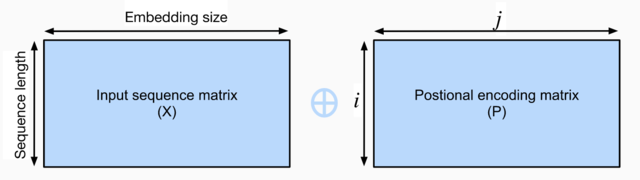

$$
Fig. 10.3.4\ 位置编码
$$


In [36]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_size, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = np.zeros((1, max_len, embedding_size))
        X = np.arange(0, max_len).reshape(-1, 1) / np.power(
            10000, np.arange(0, embedding_size, 2)/embedding_size)
        self.P[:, :, 0::2] = np.sin(X)
        self.P[:, :, 1::2] = np.cos(X)
        self.P = torch.FloatTensor(self.P)
    
    def forward(self, X):
        if X.is_cuda and not self.P.is_cuda:
            self.P = self.P.cuda()
        X = X + self.P[:, :X.shape[1], :]
        return self.dropout(X)

### 测试

下面我们用PositionalEncoding这个类进行一个小测试，取其中的四个维度进行可视化。 我们可以看到，第4维和第5维有相同的频率但偏置不同。第6维和第7维具有更低的频率；因此positional encoding对于不同维度具有可区分性。

In [37]:
import numpy as np
pe = PositionalEncoding(20, 0)
Y = pe(torch.zeros((1, 100, 20))).numpy()
d2l.plot(np.arange(100), Y[0, :, 4:8].T, figsize=(6, 2.5),
         legend=["dim %d" % p for p in [4, 5, 6, 7]])

<Figure size 432x180 with 1 Axes>

# 编码器

我们已经有了组成Transformer的各个模块，现在我们可以开始搭建了！编码器包含一个多头注意力层，一个position-wise FFN，和两个 Add and Norm层。对于attention模型以及FFN模型，我们的输出维度都是与embedding维度一致的，这也是由于残差连接天生的特性导致的，因为我们要将前一层的输出与原始输入相加并归一化。

In [38]:
class EncoderBlock(nn.Module):
    def __init__(self, embedding_size, ffn_hidden_size, num_heads,
                 dropout, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(embedding_size, embedding_size, num_heads, dropout)
        self.addnorm_1 = AddNorm(embedding_size, dropout)
        self.ffn = PositionWiseFFN(embedding_size, ffn_hidden_size, embedding_size)
        self.addnorm_2 = AddNorm(embedding_size, dropout)

    def forward(self, X, valid_length):
        Y = self.addnorm_1(X, self.attention(X, X, X, valid_length))
        return self.addnorm_2(Y, self.ffn(Y))

In [39]:
# batch_size = 2, seq_len = 100, embedding_size = 24
# ffn_hidden_size = 48, num_head = 8, dropout = 0.5

X = torch.ones((2, 100, 24))
encoder_blk = EncoderBlock(24, 48, 8, 0.5)
encoder_blk(X, valid_length).shape

torch.Size([2, 100, 24])

现在我们来实现整个Transformer 编码器模型，整个编码器由n个刚刚定义的Encoder Block堆叠而成，因为残差连接的缘故，中间状态的维度始终与嵌入向量的维度d一致；同时注意到我们把嵌入向量乘以 $\sqrt{d}$ 以防止其值过小。

In [40]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embedding_size, ffn_hidden_size,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embedding_size = embedding_size
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.pos_encoding = PositionalEncoding(embedding_size, dropout)
        self.blks = nn.ModuleList()
        for i in range(num_layers):
            self.blks.append(
                EncoderBlock(embedding_size, ffn_hidden_size,
                             num_heads, dropout))

    def forward(self, X, valid_length, *args):
        X = self.pos_encoding(self.embed(X) * math.sqrt(self.embedding_size))
        for blk in self.blks:
            X = blk(X, valid_length)
        return X

In [41]:
# test encoder
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
encoder(torch.ones((2, 100)).long(), valid_length).shape

torch.Size([2, 100, 24])

# 解码器
Transformer 模型的解码器与编码器结构类似，然而，除了之前介绍的几个模块之外，编码器部分有另一个子模块。该模块也是多头注意力层，接受编码器的输出作为key和value，decoder的状态作为query。与编码器部分相类似，解码器同样是使用了add and norm机制，用残差和层归一化将各个子层的输出相连。

仔细来讲，在第t个时间步，当前输入$x_t$是query，那么self attention接受了第t步以及前t-1步的所有输入$x_1,\ldots, x_{t-1}$。在训练时，由于第t位置的输入可以观测到全部的序列，这与预测阶段的情形项矛盾，所以我们要通过将第t个时间步所对应的可观测长度设置为t，以消除不需要看到的未来的信息。


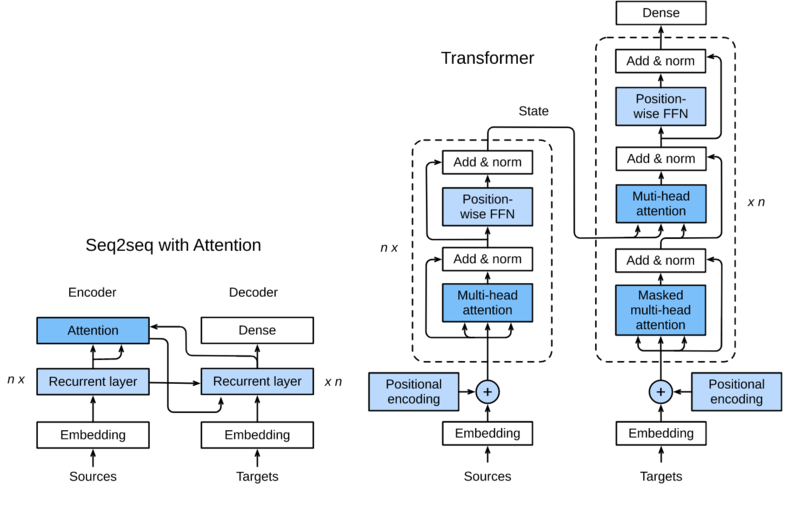


In [42]:
class DecoderBlock(nn.Module):
    def __init__(self, embedding_size, ffn_hidden_size, num_heads,dropout,i,**kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention_1 = MultiHeadAttention(embedding_size, embedding_size, num_heads, dropout)
        self.addnorm_1 = AddNorm(embedding_size, dropout)
        self.attention_2 = MultiHeadAttention(embedding_size, embedding_size, num_heads, dropout)
        self.addnorm_2 = AddNorm(embedding_size, dropout)
        self.ffn = PositionWiseFFN(embedding_size, ffn_hidden_size, embedding_size)
        self.addnorm_3 = AddNorm(embedding_size, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_length = state[0], state[1]
        
        # state[2][self.i] stores all the previous t-1 query state of layer-i
        # len(state[2]) = num_layers
        
        # If training:
        #     state[2] is useless.
        # If predicting:
        #     In the t-th timestep:
        #         state[2][self.i].shape = (batch_size, t-1, hidden_size)
        # Demo:
        # love dogs ! [EOS]
        #  |    |   |   |
        #   Transformer 
        #    Decoder
        #  |   |   |   |
        #  I love dogs !
        
        if state[2][self.i] is None:
            key_values = X
        else:
            # shape of key_values = (batch_size, t, hidden_size)
            key_values = torch.cat((state[2][self.i], X), dim=1) 
        state[2][self.i] = key_values
        
        if self.training:
            batch_size, seq_len, _ = X.shape
            # Shape: (batch_size, seq_len), the values in the j-th column are j+1
            valid_length = torch.FloatTensor(np.tile(np.arange(1, seq_len+1), (batch_size, 1))) 
            valid_length = valid_length.to(X.device)
        else:
            valid_length = None

        X2 = self.attention_1(X, key_values, key_values, valid_length)
        Y = self.addnorm_1(X, X2)
        Y2 = self.attention_2(Y, enc_outputs, enc_outputs, enc_valid_length)
        Z = self.addnorm_2(Y, Y2)
        return self.addnorm_3(Z, self.ffn(Z)), state

In [43]:
decoder_blk = DecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_length), valid_length, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

对于Transformer解码器来说，构造方式与编码器一样，除了最后一层添加一个dense layer以获得输出的置信度分数。下面让我们来实现一下Transformer Decoder，除了常规的超参数例如vocab_size embedding_size 之外，解码器还需要编码器的输出 enc_outputs 和句子有效长度 enc_valid_length。

In [44]:
class TransformerDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embedding_size, ffn_hidden_size,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.pos_encoding = PositionalEncoding(embedding_size, dropout)
        self.blks = nn.ModuleList()
        for i in range(num_layers):
            self.blks.append(
                DecoderBlock(embedding_size, ffn_hidden_size, num_heads,
                             dropout, i))
        self.dense = nn.Linear(embedding_size, vocab_size)

    def init_state(self, enc_outputs, enc_valid_length, *args):
        return [enc_outputs, enc_valid_length, [None]*self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embed(X) * math.sqrt(self.embedding_size))
        for blk in self.blks:
            X, state = blk(X, state)
        return self.dense(X), state

# 训练

In [45]:
import zipfile
import torch
import requests
from io import BytesIO
from torch.utils import data
import sys
import collections

class Vocab(object): # This class is saved in d2l.
  def __init__(self, tokens, min_freq=0, use_special_tokens=False):
    # sort by frequency and token
    counter = collections.Counter(tokens)
    token_freqs = sorted(counter.items(), key=lambda x: x[0])
    token_freqs.sort(key=lambda x: x[1], reverse=True)
    if use_special_tokens:
      # padding, begin of sentence, end of sentence, unknown
      self.pad, self.bos, self.eos, self.unk = (0, 1, 2, 3)
      tokens = ['', '', '', '']
    else:
      self.unk = 0
      tokens = ['']
    tokens += [token for token, freq in token_freqs if freq >= min_freq]
    self.idx_to_token = []
    self.token_to_idx = dict()
    for token in tokens:
      self.idx_to_token.append(token)
      self.token_to_idx[token] = len(self.idx_to_token) - 1
      
  def __len__(self):
    return len(self.idx_to_token)
  
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    else:
      return [self.__getitem__(token) for token in tokens]
    
  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    else:
      return [self.idx_to_token[index] for index in indices]

def load_data_nmt(batch_size, max_len, num_examples=1000):
    """Download an NMT dataset, return its vocabulary and data iterator."""
    # Download and preprocess
    def preprocess_raw(text):
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        out = ''
        for i, char in enumerate(text.lower()):
            if char in (',', '!', '.') and text[i-1] != ' ':
                out += ' '
            out += char
        return out 


    with open('/home/kesci/input/fraeng6506/fra.txt', 'r') as f:
      raw_text = f.read()


    text = preprocess_raw(raw_text)

    # Tokenize
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if i >= num_examples:
            break
        parts = line.split('\t')
        if len(parts) >= 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))

    # Build vocab
    def build_vocab(tokens):
        tokens = [token for line in tokens for token in line]
        return Vocab(tokens, min_freq=3, use_special_tokens=True)
    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)

    # Convert to index arrays
    def pad(line, max_len, padding_token):
        if len(line) > max_len:
            return line[:max_len]
        return line + [padding_token] * (max_len - len(line))

    def build_array(lines, vocab, max_len, is_source):
        lines = [vocab[line] for line in lines]
        if not is_source:
            lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
        array = torch.tensor([pad(line, max_len, vocab.pad) for line in lines])
        valid_len = (array != vocab.pad).sum(1)
        return array, valid_len

    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)
    src_array, src_valid_len = build_array(source, src_vocab, max_len, True)
    tgt_array, tgt_valid_len = build_array(target, tgt_vocab, max_len, False)
    train_data = data.TensorDataset(src_array, src_valid_len, tgt_array, tgt_valid_len)
    train_iter = data.DataLoader(train_data, batch_size, shuffle=True)
    return src_vocab, tgt_vocab, train_iter

In [47]:
import os

import d2l

# 平台暂时不支持gpu，现在会自动使用cpu训练，gpu可以用了之后会使用gpu来训练
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

embed_size, embedding_size, num_layers, dropout = 32, 32, 2, 0.05
batch_size, num_steps = 64, 10
lr, num_epochs, ctx = 0.005, 250, d2l.try_gpu()
print(ctx)
num_hiddens, num_heads = 64, 4

src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), embedding_size, num_hiddens, num_heads, num_layers,
    dropout)
decoder = TransformerDecoder(
    len(src_vocab), embedding_size, num_hiddens, num_heads, num_layers,
    dropout)
model = d2l.EncoderDecoder(encoder, decoder)
d2l.train_s2s_ch9(model, train_iter, lr, num_epochs, ctx)

cpu
epoch   50,loss 0.048, time 53.3 sec
epoch  100,loss 0.040, time 53.4 sec
epoch  150,loss 0.037, time 53.5 sec
epoch  200,loss 0.036, time 53.6 sec
epoch  250,loss 0.035, time 53.5 sec


In [48]:
model.eval()
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + d2l.predict_s2s_ch9(
        model, sentence, src_vocab, tgt_vocab, num_steps, ctx))

Go . =>  !
Wow ! =>  !
I'm OK . => ça va .
I won ! => j'ai gagné !
